In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

from imblearn.over_sampling import SMOTE

In [3]:
# loading datasets
actives = pd.read_csv('../../mold2_descriptors/2100_actives.csv')
inactives = pd.read_csv('../../mold2_descriptors/2100_inactives.csv')

In [4]:
print('actives:', len(actives))
print('inactives:', len(inactives))

actives: 1165
inactives: 291883


In [5]:
# spliting datasets into test - train & validation
actives_test = actives.sample(n=400, random_state=42)
actives_train = actives.drop(actives_test.index)
inactives_test = inactives.sample(n=400, random_state=42)
inactives_train = inactives.drop(inactives_test.index)

# random undersampling of inactives to prevent memory error
inactives_train = inactives_train.sample(n=100000, random_state=42)

In [6]:
df = pd.concat([actives_train, inactives_train[:1000]], ignore_index=True)

In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,1,2,0,0,0,0,0,...,0,1,0,0,0,5.12928,-0.194769,0.222222,0.731071,0
1,2,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,4.85800,0.269000,0.522000,2.839000,1
2,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.32193,-0.284751,0.400000,2.188140,0
3,1,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,4.75489,-0.708960,0.300000,2.964170,0
4,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,4.85798,-0.716962,0.260870,1.445870,0


In [8]:
X = df.drop(['activity'], axis=1)
y = df['activity']

In [9]:
y.value_counts()

0    1000
1     765
Name: activity, dtype: int64

In [10]:
import matplotlib.pyplot as plt

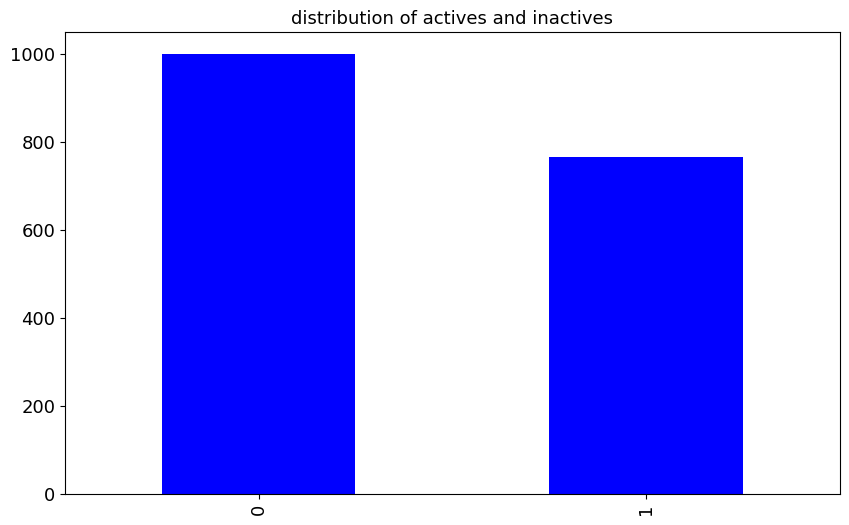

In [11]:
ax = y.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution of actives and inactives', fontsize=13)
ax.set_alpha(0.5)

In [12]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

In [14]:
over = SMOTE()
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

In [15]:
y_train_resampled.value_counts()

1    693
0    693
Name: activity, dtype: int64

Text(0.5, 1.0, 'distribution in sampled dataset')

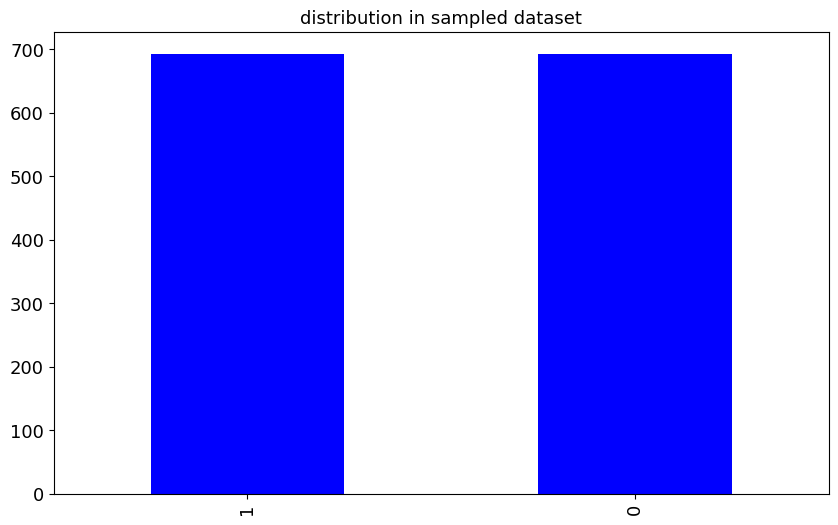

In [16]:
ax = y_train_resampled.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution in sampled dataset', fontsize=13)

## training model with oversampled data

In [17]:
import tensorflow as tf

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_resampled, y_train_resampled, validation_data=(X_validate, y_validate), epochs=50, batch_size=32)

Epoch 1/50
44/44 [==============================] - 2s 17ms/step - loss: 0.6410 - accuracy: 0.6291 - val_loss: 0.5159 - val_accuracy: 0.7396
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 0.4446 - accuracy: 0.8117 - val_loss: 0.6339 - val_accuracy: 0.7774
Epoch 3/50
44/44 [==============================] - 0s 8ms/step - loss: 0.3291 - accuracy: 0.8629 - val_loss: 0.5695 - val_accuracy: 0.7698
Epoch 4/50
44/44 [==============================] - 0s 9ms/step - loss: 0.2566 - accuracy: 0.8939 - val_loss: 0.5709 - val_accuracy: 0.7717
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 0.2026 - accuracy: 0.9163 - val_loss: 0.6486 - val_accuracy: 0.7830
Epoch 6/50
44/44 [==============================] - 0s 8ms/step - loss: 0.1692 - accuracy: 0.9307 - val_loss: 0.6734 - val_accuracy: 0.7981
Epoch 7/50
44/44 [==============================] - 0s 8ms/step - loss: 0.1318 - accuracy: 0.9538 - val_loss: 0.6120 - val_accuracy: 0.8000
Epoch 8/50
44/44 [

### evaluating the model using the test data

In [25]:
# getting the test dataset
testing_data = pd.concat([actives_test, inactives_test], ignore_index=True)

In [26]:
len(testing_data)

800

In [27]:
testing_data['activity'].value_counts()

1    400
0    400
Name: activity, dtype: int64

In [28]:
testing_data.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,5.087,0.343,0.240,0.314,1
1,0,0,0,0,3,0,0,0,0,0,...,0,1,0,0,0,5.087,-0.684,0.000,1.682,1
2,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.129,0.301,0.462,2.812,1
3,1,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.129,-0.323,0.231,1.792,1
4,2,0,0,0,3,0,0,0,0,0,...,0,0,1,0,0,5.000,-0.323,0.480,2.594,1


In [29]:
testing_data_x = testing_data.drop(['activity'], axis=1)
print(len(testing_data_x))
testing_data_x = scaler.transform(testing_data_x)
testing_data_y = testing_data['activity']

800


In [30]:
model.evaluate(testing_data_x, testing_data_y, verbose=2)

25/25 - 0s - loss: 1.9774 - accuracy: 0.8112 - 106ms/epoch - 4ms/step


[1.9774279594421387, 0.8112499713897705]

### evaluating model's performance with F1 score, precision, recall, etc

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [32]:
inactives_test_x = inactives_test.drop(['activity'], axis=1)
inactives_test_x = scaler.transform(inactives_test_x)
actives_test_x = actives_test.drop(['activity'], axis=1)
actives_test_x = scaler.transform(actives_test_x)

In [33]:
y_true_actives = np.array([1] * len(actives_test_x))
y_true_inactives = np.array([0] * len(inactives_test_x))
y_true = np.concatenate((y_true_actives, y_true_inactives))

There are both y_pred and y_pred_rounded because the model outputs a probability and we need to round it to get the class.


y_pred will be used to calculate the ROC curve and the AUC.


y_pred_rounded will be used to calculate the confusion matrix.

In [34]:
y_pred_actives = model.predict(actives_test_x)
y_pred_actives_rounded = (y_pred_actives > 0.5).astype(int).reshape(len(y_pred_actives, ))
y_pred_inactives = model.predict(inactives_test_x)
y_pred_inactives_rounded = (y_pred_inactives > 0.5).astype(int).reshape(len(y_pred_inactives, ))
y_pred = np.concatenate((y_pred_actives, y_pred_inactives))
y_pred_rounded = np.concatenate((y_pred_actives_rounded, y_pred_inactives_rounded))

13/13 [==============================] - 0s 2ms/step


In [35]:
accuracy = accuracy_score(y_true, y_pred_rounded)
precision = precision_score(y_true, y_pred_rounded)
recall = recall_score(y_true, y_pred_rounded)
f1 = f1_score(y_true, y_pred_rounded)

In [36]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.81125
precision is 0.8233766233766234
recall is 0.7925
f1 is 0.8076433121019109


Drawing the ROC curve to enable us to carry out threshold moving,

In [37]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

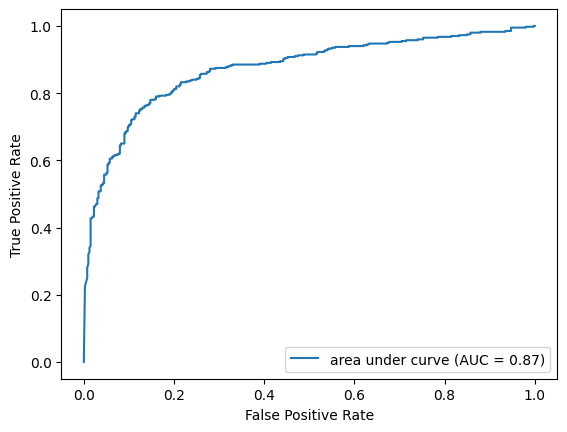

In [38]:
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='area under curve')
display.plot()
plt.show()

In [39]:
fav_thresholds = []
for i in range(len(thresholds)):
    if fpr[i] < 0.25 and tpr[i] > 0.8:
        fav_thresholds.append((i, thresholds[i], fpr[i], tpr[i]))

In [40]:
for i in fav_thresholds:
    print(i)

(115, 0.20479149, 0.195, 0.805)
(116, 0.1912449, 0.1975, 0.805)
(117, 0.19118553, 0.1975, 0.8075)
(118, 0.18472824, 0.2, 0.8075)
(119, 0.17800517, 0.2, 0.8125)
(120, 0.15702182, 0.205, 0.8125)
(121, 0.14983152, 0.205, 0.82)
(122, 0.08092195, 0.2125, 0.82)
(123, 0.0702553, 0.2125, 0.825)
(124, 0.06427922, 0.215, 0.825)
(125, 0.04912352, 0.215, 0.8325)
(126, 0.036289383, 0.2275, 0.8325)
(127, 0.035417702, 0.2275, 0.835)
(128, 0.024346195, 0.235, 0.835)
(129, 0.02420027, 0.235, 0.8375)
(130, 0.018370898, 0.24, 0.8375)
(131, 0.015193693, 0.24, 0.84)


In [41]:
selected_threshold = fav_thresholds[-1][1]
selected_threshold

0.015193693

In [42]:
y_pred_actives_rounded2 = (y_pred_actives > selected_threshold).astype(int).reshape(len(y_pred_actives, ))
y_pred_inactives_rounded2 = (y_pred_inactives > selected_threshold).astype(int).reshape(len(y_pred_inactives, ))
y_pred_rounded2 = np.concatenate((y_pred_actives_rounded2, y_pred_inactives_rounded2))

In [43]:
accuracy = accuracy_score(y_true, y_pred_rounded2)
precision = precision_score(y_true, y_pred_rounded2)
recall = recall_score(y_true, y_pred_rounded2)
f1 = f1_score(y_true, y_pred_rounded2)

In [44]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.79875
precision is 0.777262180974478
recall is 0.8375
f1 is 0.8062575210589652
